 
 
 
# Qubit Audio Synthesis

It's kinda like wavetable synthesis
[[github repo](https://github.com/Cortexelus/qubit-audio-synthesis)]
cj carr 2020

*this code is super experimental, i put it together in a few hours*

In [2]:
import numpy as np
pi = np.pi
import matplotlib.pyplot as plt
import librosa
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ, ClassicalRegister, QuantumRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.quantum_info import Pauli, state_fidelity, basis_state, process_fidelity
from qiskit.providers.aer import StatevectorSimulator
import soundfile as sf

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


In [5]:
# Construct quantum circuit 
sr = 44100 # sample rate of audio
f = 90 # frequency
n = int(np.ceil(sr/f)) # number of samples in wavetable
print(n)

qclist = []
for i in range(n):
    # for evey sample
    qc = QuantumCircuit(1,1)
    # phase clock
    qc.h(0)
    qc.ry(i/n * 2*pi,0)
    
    # begin "creative" section..
    # make an arbitrary quantum circuit here
    qc.rz(3.6 * i/n * 9*pi,0)
    qc.rx(7 * i/n * 0.9*pi,0)
    qc.s(0)

    # ..end "creative" section
    # the output is the amplitude of the statevector
    # todo: collapse to classical register when running on real computer
    qclist.append(qc)
    
# Select the StatevectorSimulator from the Aer provider
simulator = Aer.get_backend('statevector_simulator')

# Execute and get counts
result = execute(qclist, simulator).result()

490


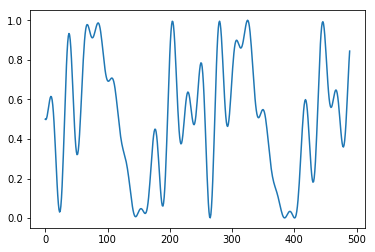

In [15]:
# convert statevector results into a list of magnitudes

wavetable = []
for i in range(n):
    sv = result.get_statevector(qclist[i])
    mag = np.power(np.abs(sv),2)
    assert mag[0]+mag[1]-1 < 1e-9
    wavetable.append(mag[0])
plt.plot(wavetable)

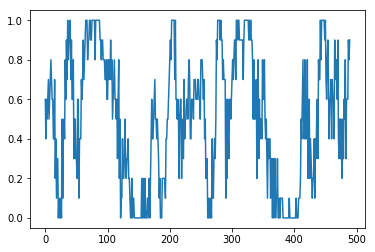

In [16]:
## add noise to the waveform 
## by simulating multiple shots
## you could also achieve this by collapsing the output qubit statevector to a classical register
## which you need to do if you're running it on a real quantum computer

shots = 10
wavetable_r = []
for i in range(len(wavetable)):
    mag = wavetable[i]
    r = np.random.binomial(shots,mag,1)/shots
    wavetable_r.append(r)

plt.plot(wavetable_r)

450 (220500,)


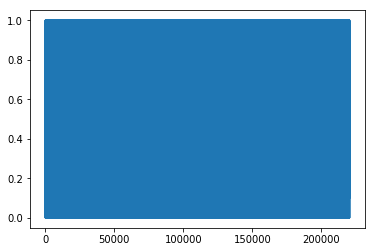

In [24]:
# repeat the waveform to fill an audio file

# use the clean one 
# w = wavetable 
# use the noisy one 
w = wavetable_r

ylen = 5 # the output wave file is __ seconds long
ysamps = ylen * sr # the length of the output wave file in samples
yreps = int(np.ceil(ysamps / len(w))) # how many repeats of the waveform
w = np.tile(np.squeeze(np.array(w)), yreps)
print(yreps, w_out.shape)
w = w[:ysamps] # trim 
#print(w.shape)
plt.plot(w)
plt.show()

(220500,)
(220500,)


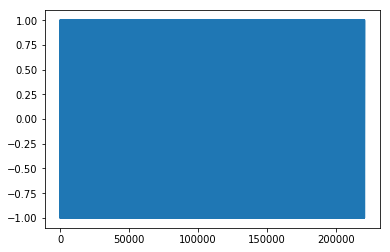

In [436]:
# normalize
wt = w
wt = np.squeeze(np.array(wt))
wt -= 0.5
wt /= np.max(np.abs(wt))
print(wt.shape)
plt.plot(wt)

y = wt
print(y.shape)
# output
sf.write('quantum_test.wav', y, 44100, 'PCM_24')